In [2]:

import os
import glob



In [3]:
#change directories below depending on the folder with hyperparameters you want to use.

tensor_paths = glob.glob('./FINISHED_PRODUCT_thresh_0.5_step_0.1/*_combined.pt')
label_paths = glob.glob('./FINISHED_PRODUCT_thresh_0.5_step_0.1/*_label.pt')
# Print out the paths to ensure they are not empty
#print(f"Tensor paths: {tensor_paths}")
#print(f"Label paths: {label_paths}")


In [18]:
# trying to change the stuff such that it doesn't mess up the accuracy
# mainly addressing the issue of having spectrograms from the same audio file in validation, training and test
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from collections import defaultdict
import time

class CustomTensorDataset(Dataset):
    def __init__(self, tensor_paths, label_paths):
        self.tensor_paths = tensor_paths
        self.label_paths = label_paths

    def __len__(self):
        return len(self.tensor_paths)

    def __getitem__(self, idx):
        tensor = torch.load(self.tensor_paths[idx],weights_only=True)
        label = torch.load(self.label_paths[idx],weights_only=True)
        return tensor, label

def group_paths_by_audio_file(tensor_paths, label_paths):
    grouped_tensor_paths = defaultdict(list)
    grouped_label_paths = defaultdict(list)

    for tensor_path, label_path in zip(tensor_paths, label_paths):
        base_name = '_'.join(os.path.basename(tensor_path).split('_')[:-2])
        grouped_tensor_paths[base_name].append(tensor_path)
        grouped_label_paths[base_name].append(label_path)

    return list(grouped_tensor_paths.values()), list(grouped_label_paths.values())


# Ensure the tensor and label paths are sorted so they match
tensor_paths.sort()
label_paths.sort()

# Group paths by audio file
grouped_tensor_paths, grouped_label_paths = group_paths_by_audio_file(tensor_paths, label_paths)

# Ensure there are tensors and labels
assert len(grouped_tensor_paths) > 0, "No tensor files found."
assert len(grouped_label_paths) > 0, "No label files found."

# Split groups into training, validation, and testing sets
num_files = len(grouped_tensor_paths)
print("Number of files is: ", num_files)
train_size = int(0.7 * num_files)
val_size = int(0.15 * num_files)
test_size = num_files - train_size - val_size

from torch.utils.data import random_split

# Split groups into training, validation, and testing sets based on tensor groups
num_files = len(grouped_tensor_paths)
train_size = int(0.7 * num_files)
val_size = int(0.15 * num_files)
test_size = num_files - train_size - val_size

# Perform random split on the tensor groups
train_tensor_groups, val_tensor_groups, test_tensor_groups = random_split(grouped_tensor_paths, [train_size, val_size, test_size])

# Use the same split for the corresponding label groups
train_label_groups = [grouped_label_paths[i] for i in range(len(grouped_label_paths)) if grouped_tensor_paths[i] in train_tensor_groups]
val_label_groups = [grouped_label_paths[i] for i in range(len(grouped_label_paths)) if grouped_tensor_paths[i] in val_tensor_groups]
test_label_groups = [grouped_label_paths[i] for i in range(len(grouped_label_paths)) if grouped_tensor_paths[i] in test_tensor_groups]

# Flatten the grouped lists
train_tensors = [item for sublist in train_tensor_groups for item in sublist]
train_labels = [item for sublist in train_label_groups for item in sublist]
val_tensors = [item for sublist in val_tensor_groups for item in sublist]
val_labels = [item for sublist in val_label_groups for item in sublist]
test_tensors = [item for sublist in test_tensor_groups for item in sublist]
test_labels = [item for sublist in test_label_groups for item in sublist]

# Assert lengths to ensure tensors and labels match
assert len(train_tensors) == len(train_labels), "Mismatch in training tensors and labels."
assert len(val_tensors) == len(val_labels), "Mismatch in validation tensors and labels."
assert len(test_tensors) == len(test_labels), "Mismatch in test tensors and labels."

# Create datasets and data loaders
train_dataset = CustomTensorDataset(train_tensors, train_labels)
val_dataset = CustomTensorDataset(val_tensors, val_labels)
test_dataset = CustomTensorDataset(test_tensors, test_labels)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"total: {len(train_dataset)+len(val_dataset)+len(test_dataset)}")

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("all processed!")

Number of files is:  110
Train dataset size: 5780
Validation dataset size: 1094
Test dataset size: 1585
total: 8459
all processed!


In [19]:
for data, labels in train_loader:
    print(f"Train batch - data shape: {data.shape}, labels shape: {labels.shape}")
    break

for data, labels in val_loader:
    print(f"Validation batch - data shape: {data.shape}, labels shape: {labels.shape}")
    break

for data, labels in test_loader:
    print(f"Test batch - data shape: {data.shape}, labels shape: {labels.shape}")
    break


Train batch - data shape: torch.Size([32, 3, 128, 128]), labels shape: torch.Size([32])
Validation batch - data shape: torch.Size([32, 3, 128, 128]), labels shape: torch.Size([32])
Test batch - data shape: torch.Size([32, 3, 128, 128]), labels shape: torch.Size([32])


In [20]:
#check there isn't any overlap
train_set = set([os.path.basename(p).split('_segment')[0] for p in train_tensors])
val_set = set([os.path.basename(p).split('_segment')[0] for p in val_tensors])
test_set = set([os.path.basename(p).split('_segment')[0] for p in test_tensors])

assert len(train_set.intersection(val_set)) == 0, "Overlap between training and validation sets!"
assert len(train_set.intersection(test_set)) == 0, "Overlap between training and test sets!"
assert len(val_set.intersection(test_set)) == 0, "Overlap between validation and test sets!"


In [21]:
#Resnet implementation of it
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=2):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet18(num_classes=2):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

# Example usage:
model = resnet18(num_classes=2)
# model = model.to(device)


In [26]:
#GNet - which is just a modifies google-net for 3x128x128 input files
import torch
import torch.nn as nn
import torch.nn.functional as F

class InceptionModule(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3reduce, ch3x3, ch5x5reduce, ch5x5, pool_proj):
        super(InceptionModule, self).__init__()
        self.branch1 = nn.Conv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3reduce, kernel_size=1),
            nn.Conv2d(ch3x3reduce, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5reduce, kernel_size=1),
            nn.Conv2d(ch5x5reduce, ch5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)

class GNet(nn.Module):
    def __init__(self):
        super(GNet, self).__init__()

        #Upsample to get the input size from 64x128 to 128x128
        #self.upsample = nn.Upsample(size=(128, 128), mode='bilinear', align_corners=True)

        # Initial layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2 = nn.Conv2d(16, 48, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception modules
        self.inception3a = InceptionModule(48, 64, 48, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size=8, stride=1)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, 2)

    def forward(self, x):
        #x = self.upsamle(x)
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)

        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        x = F.softmax(x, dim=1)

        return x


In [22]:
print(f"Number of train tensors: {len(train_tensors)}, Number of train labels: {len(train_labels)}")
print(f"Number of val tensors: {len(val_tensors)}, Number of val labels: {len(val_labels)}")
print(f"Number of test tensors: {len(test_tensors)}, Number of test labels: {len(test_labels)}")


Number of train tensors: 5780, Number of train labels: 5780
Number of val tensors: 1094, Number of val labels: 1094
Number of test tensors: 1585, Number of test labels: 1585


In [23]:
# Check if MPS is available and set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
model = resnet18(num_classes=2)
#model = GNet()
model.to(device)

print("caluclating class weights")
# Calculate class weights
total_labels = torch.cat([labels for _, labels in DataLoader(train_dataset, batch_size=len(train_dataset))], dim=0)
total_0 = (total_labels == 0).sum().item()
total_1 = (total_labels == 1).sum().item()
class_weights = torch.tensor([1.0, 5.0], dtype=torch.float)  # Adjust the weight for class 1 as needed
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 10
start_time = time.time()

print("starting training")
# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    correct_0 = 0
    total_0 = 0
    correct_1 = 0
    total_1 = 0

    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(val_loader):
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_0 += (labels == 0).sum().item()
            correct_0 += ((predicted == labels) & (labels == 0)).sum().item()
            total_1 += (labels == 1).sum().item()
            correct_1 += ((predicted == labels) & (labels == 1)).sum().item()

    val_loss /= len(val_loader)
    val_accuracy_0 = correct_0 / total_0 if total_0 > 0 else 0
    val_accuracy_1 = correct_1 / total_1 if total_1 > 0 else 0

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy (0s): {val_accuracy_0:.4f}, Val Accuracy (1s): {val_accuracy_1:.4f}')

end_time = time.time()

# Save the model
torch.save(model.state_dict(), './resnet18_model_state.pth')

# Testing phase
model.eval()
test_loss = 0.0
correct_0 = 0
total_0 = 0
correct_1 = 0
total_1 = 0

with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(test_loader):
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_0 += (labels == 0).sum().item()
        correct_0 += ((predicted == labels) & (labels == 0)).sum().item()
        total_1 += (labels == 1).sum().item()
        correct_1 += ((predicted == labels) & (labels == 1)).sum().item()

test_loss /= len(test_loader)
test_accuracy_0 = correct_0 / total_0 if total_0 > 0 else 0
test_accuracy_1 = correct_1 / total_1 if total_1 > 0 else 0

print(f'Test Loss: {test_loss:.4f}, Test Accuracy (0s): {test_accuracy_0:.4f}, Test Accuracy (1s): {test_accuracy_1:.4f}')
print(f'Training completed in: {end_time - start_time:.2f} seconds')

Using device: mps
caluclating class weights
starting training
Epoch [1/10], Train Loss: 0.8377, Val Loss: 0.8912, Val Accuracy (0s): 1.0000, Val Accuracy (1s): 0.0000
Epoch [2/10], Train Loss: 0.7478, Val Loss: 1.0253, Val Accuracy (0s): 0.0000, Val Accuracy (1s): 1.0000
Epoch [3/10], Train Loss: 0.6636, Val Loss: 0.6957, Val Accuracy (0s): 0.8708, Val Accuracy (1s): 0.1531
Epoch [4/10], Train Loss: 0.6483, Val Loss: 0.7578, Val Accuracy (0s): 0.3062, Val Accuracy (1s): 0.5867
Epoch [5/10], Train Loss: 0.6138, Val Loss: 0.9384, Val Accuracy (0s): 0.1938, Val Accuracy (1s): 0.5867
Epoch [6/10], Train Loss: 0.5415, Val Loss: 0.8638, Val Accuracy (0s): 0.4733, Val Accuracy (1s): 0.3673
Epoch [7/10], Train Loss: 0.4965, Val Loss: 0.8754, Val Accuracy (0s): 0.7316, Val Accuracy (1s): 0.1939
Epoch [8/10], Train Loss: 0.4370, Val Loss: 1.0983, Val Accuracy (0s): 0.5323, Val Accuracy (1s): 0.3980
Epoch [9/10], Train Loss: 0.3638, Val Loss: 1.1228, Val Accuracy (0s): 0.5824, Val Accuracy (1s): 

In [27]:
# Check if MPS is available and set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
#model = resnet18(num_classes=2)
model = GNet()
model.to(device)

print("caluclating class weights")
# Calculate class weights
total_labels = torch.cat([labels for _, labels in DataLoader(train_dataset, batch_size=len(train_dataset))], dim=0)
total_0 = (total_labels == 0).sum().item()
total_1 = (total_labels == 1).sum().item()
class_weights = torch.tensor([1.0, 5.0], dtype=torch.float)  # Adjust the weight for class 1 as needed
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 10
start_time = time.time()

print("starting training")
# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    correct_0 = 0
    total_0 = 0
    correct_1 = 0
    total_1 = 0

    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(val_loader):
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_0 += (labels == 0).sum().item()
            correct_0 += ((predicted == labels) & (labels == 0)).sum().item()
            total_1 += (labels == 1).sum().item()
            correct_1 += ((predicted == labels) & (labels == 1)).sum().item()

    val_loss /= len(val_loader)
    val_accuracy_0 = correct_0 / total_0 if total_0 > 0 else 0
    val_accuracy_1 = correct_1 / total_1 if total_1 > 0 else 0

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy (0s): {val_accuracy_0:.4f}, Val Accuracy (1s): {val_accuracy_1:.4f}')

end_time = time.time()

# Save the model
torch.save(model.state_dict(), './resnet18_model_state.pth')

# Testing phase
model.eval()
test_loss = 0.0
correct_0 = 0
total_0 = 0
correct_1 = 0
total_1 = 0

with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(test_loader):
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_0 += (labels == 0).sum().item()
        correct_0 += ((predicted == labels) & (labels == 0)).sum().item()
        total_1 += (labels == 1).sum().item()
        correct_1 += ((predicted == labels) & (labels == 1)).sum().item()

test_loss /= len(test_loader)
test_accuracy_0 = correct_0 / total_0 if total_0 > 0 else 0
test_accuracy_1 = correct_1 / total_1 if total_1 > 0 else 0

print(f'Test Loss: {test_loss:.4f}, Test Accuracy (0s): {test_accuracy_0:.4f}, Test Accuracy (1s): {test_accuracy_1:.4f}')
print(f'Training completed in: {end_time - start_time:.2f} seconds')

Using device: mps
caluclating class weights
starting training
Epoch [1/10], Train Loss: 0.6800, Val Loss: 0.6468, Val Accuracy (0s): 1.0000, Val Accuracy (1s): 0.0000
Epoch [2/10], Train Loss: 0.6768, Val Loss: 0.6339, Val Accuracy (0s): 1.0000, Val Accuracy (1s): 0.0000
Epoch [3/10], Train Loss: 0.6775, Val Loss: 0.6491, Val Accuracy (0s): 1.0000, Val Accuracy (1s): 0.0000
Epoch [4/10], Train Loss: 0.6783, Val Loss: 0.6368, Val Accuracy (0s): 1.0000, Val Accuracy (1s): 0.0000
Epoch [5/10], Train Loss: 0.6787, Val Loss: 0.6479, Val Accuracy (0s): 1.0000, Val Accuracy (1s): 0.0000
Epoch [6/10], Train Loss: 0.6783, Val Loss: 0.6359, Val Accuracy (0s): 1.0000, Val Accuracy (1s): 0.0000
Epoch [7/10], Train Loss: 0.6779, Val Loss: 0.6364, Val Accuracy (0s): 1.0000, Val Accuracy (1s): 0.0000
Epoch [8/10], Train Loss: 0.6770, Val Loss: 0.6352, Val Accuracy (0s): 1.0000, Val Accuracy (1s): 0.0000
Epoch [9/10], Train Loss: 0.6782, Val Loss: 0.6401, Val Accuracy (0s): 1.0000, Val Accuracy (1s): 

# DO IT ON ALL THE NEW PATHS


Using device: mps
Processing folder: ./FINISHED_PRODUCT_thresh_0.7_step_0.05
Processing folder: ./FINISHED_PRODUCT_thresh_0.2_step_0.2
Processing folder: ./FINISHED_PRODUCT_thresh_0.65_step_0.1
Processing folder: ./FINISHED_PRODUCT_thresh_0.65_step_0.05
Processing folder: ./FINISHED_PRODUCT_thresh_0.4_step_0.2
Processing folder: ./FINISHED_PRODUCT_thresh_0.6_step_0.05
Processing folder: ./FINISHED_PRODUCT_thresh_0.6_step_0.1
Processing folder: ./FINISHED_PRODUCT_thresh_0.7_step_0.1
Processing folder: ./FINISHED_PRODUCT_thresh_0.2_step_0.1
Processing folder: ./FINISHED_PRODUCT_thresh_0.65_step_0.2
Processing folder: ./FINISHED_PRODUCT_thresh_0.5_step_0.1
Processing folder: ./FINISHED_PRODUCT_thresh_0.4_step_0.1
Processing folder: ./FINISHED_PRODUCT_thresh_0.4_step_0.05
Processing folder: ./FINISHED_PRODUCT_thresh_0.2_step_0.05
Processing folder: ./FINISHED_PRODUCT_thresh_0.6_step_0.2
Processing folder: ./FINISHED_PRODUCT_thresh_0.7_step_0.2


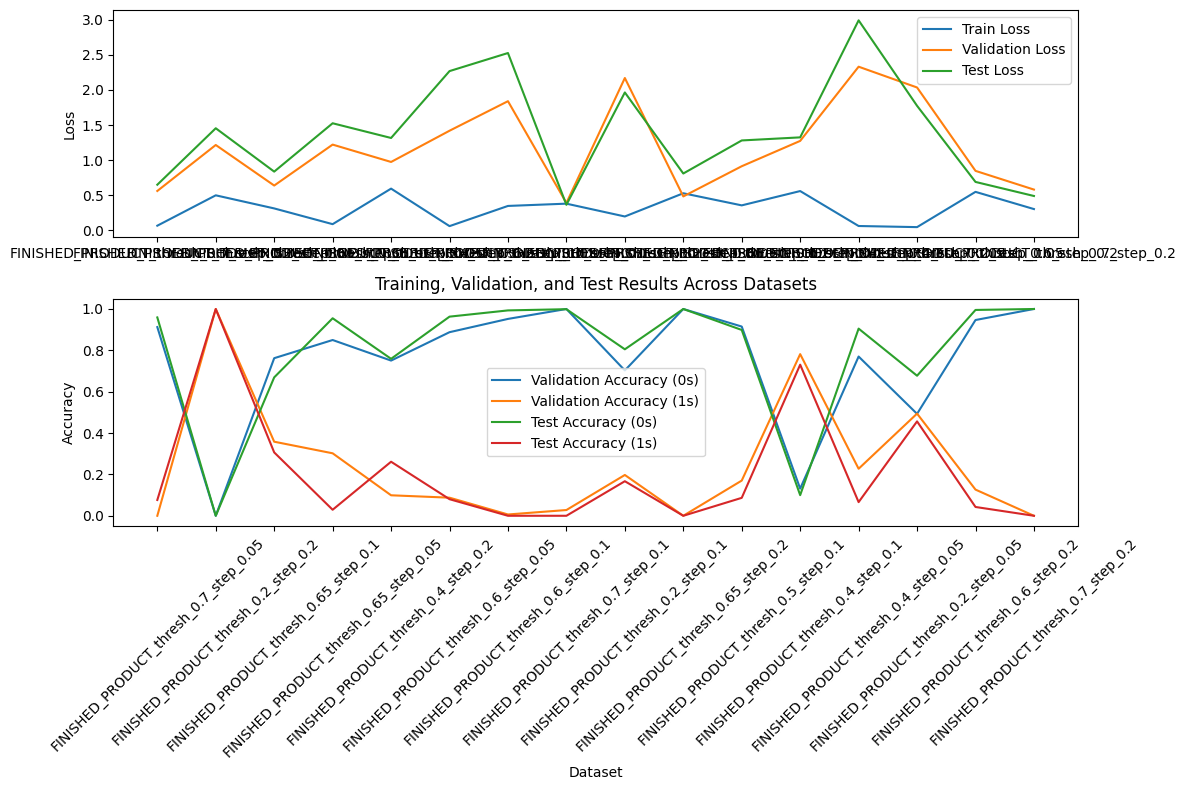

In [29]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from collections import defaultdict
import time
import matplotlib.pyplot as plt

class CustomTensorDataset(Dataset):
    def __init__(self, tensor_paths, label_paths):
        self.tensor_paths = tensor_paths
        self.label_paths = label_paths

    def __len__(self):
        return len(self.tensor_paths)

    def __getitem__(self, idx):
        tensor = torch.load(self.tensor_paths[idx], weights_only=True)
        label = torch.load(self.label_paths[idx], weights_only=True)
        return tensor, label

def group_paths_by_audio_file(tensor_paths, label_paths):
    grouped_tensor_paths = defaultdict(list)
    grouped_label_paths = defaultdict(list)

    for tensor_path, label_path in zip(tensor_paths, label_paths):
        base_name = '_'.join(os.path.basename(tensor_path).split('_')[:-2])
        grouped_tensor_paths[base_name].append(tensor_path)
        grouped_label_paths[base_name].append(label_path)

    return list(grouped_tensor_paths.values()), list(grouped_label_paths.values())

def train_and_evaluate(data_folder, device):
    # Get tensor and label paths
    tensor_paths = glob.glob(os.path.join(data_folder, '*_combined.pt'))
    label_paths = glob.glob(os.path.join(data_folder, '*_label.pt'))

    # Ensure the tensor and label paths are sorted so they match
    tensor_paths.sort()
    label_paths.sort()

    # Group paths by audio file
    grouped_tensor_paths, grouped_label_paths = group_paths_by_audio_file(tensor_paths, label_paths)

    # Ensure there are tensors and labels
    assert len(grouped_tensor_paths) > 0, "No tensor files found."
    assert len(grouped_label_paths) > 0, "No label files found."

    # Split groups into training, validation, and testing sets
    num_files = len(grouped_tensor_paths)
    train_size = int(0.7 * num_files)
    val_size = int(0.15 * num_files)
    test_size = num_files - train_size - val_size

    # Perform random split on the tensor groups
    train_tensor_groups, val_tensor_groups, test_tensor_groups = random_split(grouped_tensor_paths, [train_size, val_size, test_size])

    # Use the same split for the corresponding label groups
    train_label_groups = [grouped_label_paths[i] for i in range(len(grouped_label_paths)) if grouped_tensor_paths[i] in train_tensor_groups]
    val_label_groups = [grouped_label_paths[i] for i in range(len(grouped_label_paths)) if grouped_tensor_paths[i] in val_tensor_groups]
    test_label_groups = [grouped_label_paths[i] for i in range(len(grouped_label_paths)) if grouped_tensor_paths[i] in test_tensor_groups]

    # Flatten the grouped lists
    train_tensors = [item for sublist in train_tensor_groups for item in sublist]
    train_labels = [item for sublist in train_label_groups for item in sublist]
    val_tensors = [item for sublist in val_tensor_groups for item in sublist]
    val_labels = [item for sublist in val_label_groups for item in sublist]
    test_tensors = [item for sublist in test_tensor_groups for item in sublist]
    test_labels = [item for sublist in test_label_groups for item in sublist]

    # Assert lengths to ensure tensors and labels match
    assert len(train_tensors) == len(train_labels), "Mismatch in training tensors and labels."
    assert len(val_tensors) == len(val_labels), "Mismatch in validation tensors and labels."
    assert len(test_tensors) == len(test_labels), "Mismatch in test tensors and labels."

    # Create datasets and data loaders
    train_dataset = CustomTensorDataset(train_tensors, train_labels)
    val_dataset = CustomTensorDataset(val_tensors, val_labels)
    test_dataset = CustomTensorDataset(test_tensors, test_labels)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    model = resnet18(num_classes=2)
    model.to(device)

    # Calculate class weights
    total_labels = torch.cat([labels for _, labels in DataLoader(train_dataset, batch_size=len(train_dataset))], dim=0)
    total_0 = (total_labels == 0).sum().item()
    total_1 = (total_labels == 1).sum().item()
    class_weights = torch.tensor([1.0, 5.0], dtype=torch.float)  # Adjust the weight for class 1 as needed
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

    # Optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    num_epochs = 10

    # Training and validation loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch_idx, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0.0
        correct_0 = 0
        total_0 = 0
        correct_1 = 0
        total_1 = 0

        with torch.no_grad():
            for batch_idx, (data, labels) in enumerate(val_loader):
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_0 += (labels == 0).sum().item()
                correct_0 += ((predicted == labels) & (labels == 0)).sum().item()
                total_1 += (labels == 1).sum().item()
                correct_1 += ((predicted == labels) & (labels == 1)).sum().item()

        val_loss /= len(val_loader)
        val_accuracy_0 = correct_0 / total_0 if total_0 > 0 else 0
        val_accuracy_1 = correct_1 / total_1 if total_1 > 0 else 0

    # Testing phase
    model.eval()
    test_loss = 0.0
    correct_0 = 0
    total_0 = 0
    correct_1 = 0
    total_1 = 0

    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(test_loader):
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_0 += (labels == 0).sum().item()
            correct_0 += ((predicted == labels) & (labels == 0)).sum().item()
            total_1 += (labels == 1).sum().item()
            correct_1 += ((predicted == labels) & (labels == 1)).sum().item()

    test_loss /= len(test_loader)
    test_accuracy_0 = correct_0 / total_0 if total_0 > 0 else 0
    test_accuracy_1 = correct_1 / total_1 if total_1 > 0 else 0

    return train_loss, val_loss, test_loss, val_accuracy_0, val_accuracy_1, test_accuracy_0, test_accuracy_1

def visualize_results(results):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    # Unpack results
    train_losses, val_losses, test_losses = [], [], []
    val_accuracies_0, val_accuracies_1, test_accuracies_0, test_accuracies_1 = [], [], [], []
    labels = []

    for label, res in results.items():
        train_loss, val_loss, test_loss, val_accuracy_0, val_accuracy_1, test_accuracy_0, test_accuracy_1 = res
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)
        val_accuracies_0.append(val_accuracy_0)
        val_accuracies_1.append(val_accuracy_1)
        test_accuracies_0.append(test_accuracy_0)
        test_accuracies_1.append(test_accuracy_1)
        labels.append(label)

    # Plot losses
    axes[0].plot(labels, train_losses, label="Train Loss")
    axes[0].plot(labels, val_losses, label="Validation Loss")
    axes[0].plot(labels, test_losses, label="Test Loss")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Plot accuracies
    axes[1].plot(labels, val_accuracies_0, label="Validation Accuracy (0s)")
    axes[1].plot(labels, val_accuracies_1, label="Validation Accuracy (1s)")
    axes[1].plot(labels, test_accuracies_0, label="Test Accuracy (0s)")
    axes[1].plot(labels, test_accuracies_1, label="Test Accuracy (1s)")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.xlabel("Dataset")
    plt.title("Training, Validation, and Test Results Across Datasets")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Main Loop
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

results = {}

# Iterate through all created folders in "./" with "FINISHED_PRODUCT" in their name
for data_folder in os.listdir("./"):
    data_folder_path = os.path.join("./", data_folder)
    if os.path.isdir(data_folder_path) and "FINISHED_PRODUCT" in data_folder:
        print(f"Processing folder: {data_folder_path}")
        results[data_folder] = train_and_evaluate(data_folder_path, device)

# Visualize the results
visualize_results(results)


In [ ]:
def visualize_results(results):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    # Unpack results
    train_losses, val_losses, test_losses = [], [], []
    val_accuracies_0, val_accuracies_1, test_accuracies_0, test_accuracies_1 = [], [], [], []
    labels = []

    for label, res in results.items():
        train_loss, val_loss, test_loss, val_accuracy_0, val_accuracy_1, test_accuracy_0, test_accuracy_1 = res
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)
        val_accuracies_0.append(val_accuracy_0)
        val_accuracies_1.append(val_accuracy_1)
        test_accuracies_0.append(test_accuracy_0)
        test_accuracies_1.append(test_accuracy_1)
        labels.append(label)

    # Plot losses
    axes[0].plot(labels, train_losses, label="Train Loss")
    axes[0].plot(labels, val_losses, label="Validation Loss")
    axes[0].plot(labels, test_losses, label="Test Loss")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Plot accuracies
    axes[1].plot(labels, val_accuracies_0, label="Validation Accuracy (0s)")
    axes[1].plot(labels, val_accuracies_1, label="Validation Accuracy (1s)")
    axes[1].plot(labels, test_accuracies_0, label="Test Accuracy (0s)")
    axes[1].plot(labels, test_accuracies_1, label="Test Accuracy (1s)")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.xlabel("Dataset")
    plt.title("Training, Validation, and Test Results Across Datasets")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
visualize_results(results)

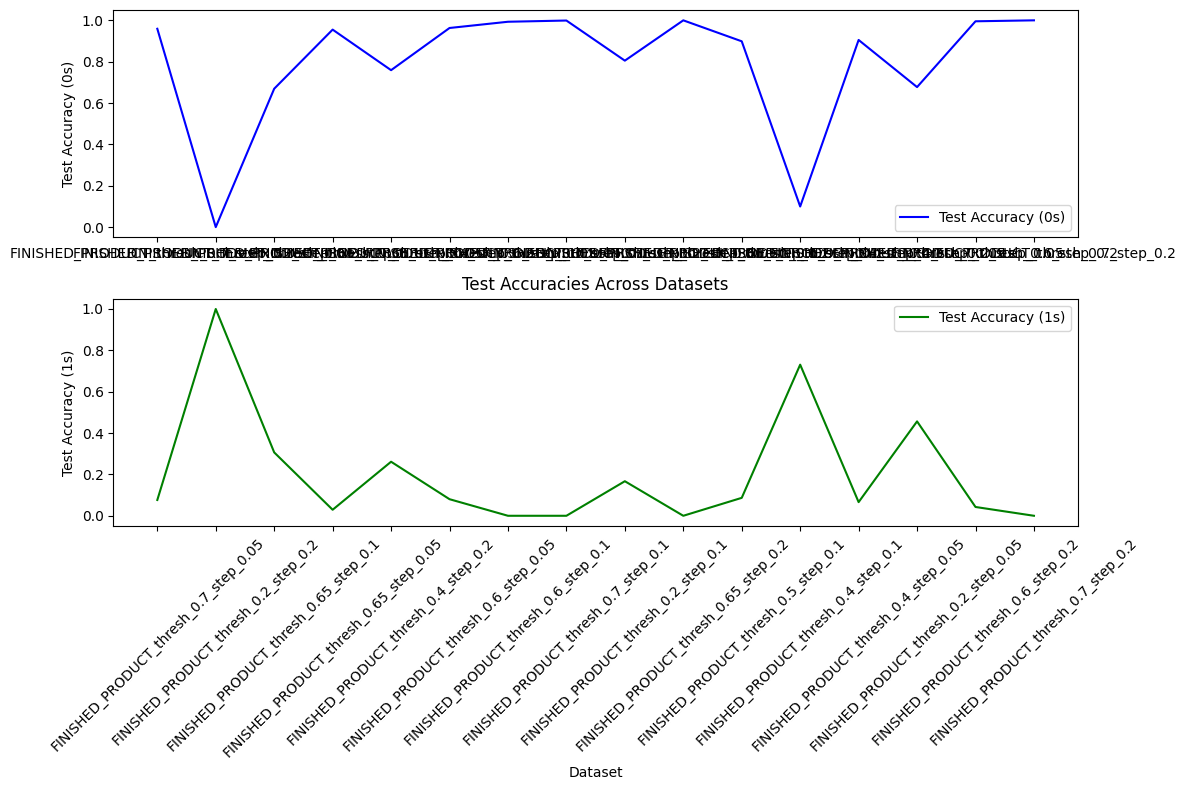

In [30]:
def visualize_test_accuracies(results):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    # Unpack results
    test_accuracies_0, test_accuracies_1 = [], []
    labels = []

    for label, res in results.items():
        _, _, _, _, _, test_accuracy_0, test_accuracy_1 = res
        test_accuracies_0.append(test_accuracy_0)
        test_accuracies_1.append(test_accuracy_1)
        labels.append(label)

    # Plot test accuracy for 0s
    axes[0].plot(labels, test_accuracies_0, label="Test Accuracy (0s)", color='blue')
    axes[0].set_ylabel("Test Accuracy (0s)")
    axes[0].legend()

    # Plot test accuracy for 1s
    axes[1].plot(labels, test_accuracies_1, label="Test Accuracy (1s)", color='green')
    axes[1].set_ylabel("Test Accuracy (1s)")
    axes[1].legend()

    plt.xlabel("Dataset")
    plt.title("Test Accuracies Across Datasets")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the function to visualize test accuracies
visualize_test_accuracies(results)


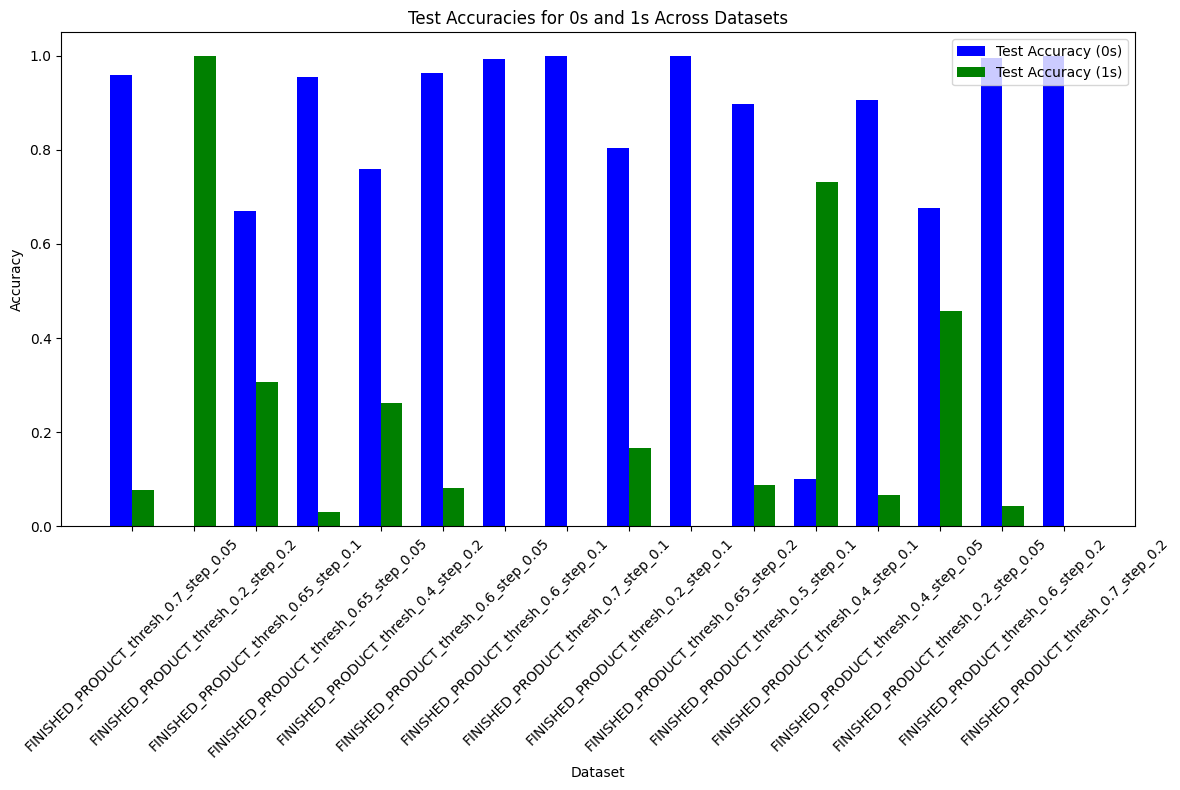

In [31]:
import numpy as np

def visualize_test_accuracies_bar(results):
    labels = list(results.keys())
    test_accuracies_0 = [res[5] for res in results.values()]
    test_accuracies_1 = [res[6] for res in results.values()]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.bar(x - width/2, test_accuracies_0, width, label='Test Accuracy (0s)', color='blue')
    ax.bar(x + width/2, test_accuracies_1, width, label='Test Accuracy (1s)', color='green')

    ax.set_xlabel('Dataset')
    ax.set_ylabel('Accuracy')
    ax.set_title('Test Accuracies for 0s and 1s Across Datasets')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()

visualize_test_accuracies_bar(results)


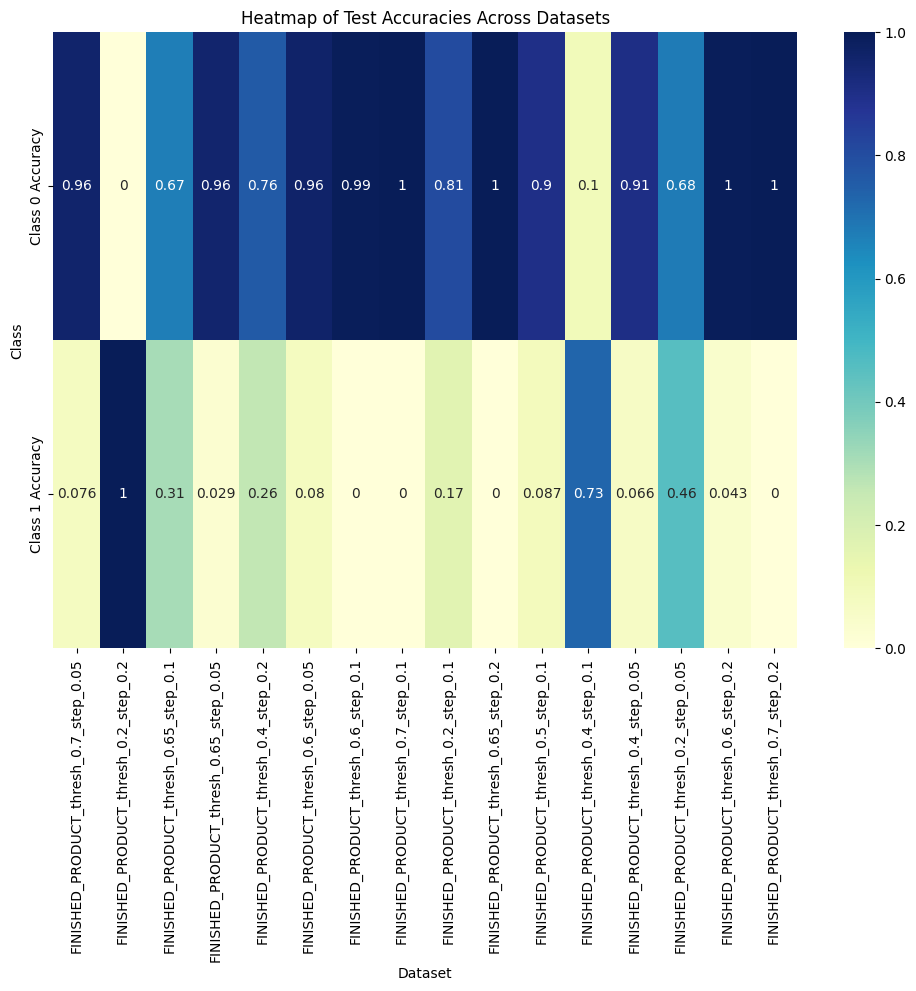

In [34]:
import seaborn as sns
import pandas as pd
def visualize_test_accuracies_heatmap(results):
    data = {
        "Dataset": [],
        "Class 0 Accuracy": [],
        "Class 1 Accuracy": []
    }

    for label, res in results.items():
        data["Dataset"].append(label)
        data["Class 0 Accuracy"].append(res[5])
        data["Class 1 Accuracy"].append(res[6])

    df = pd.DataFrame(data)
    df.set_index("Dataset", inplace=True)

    plt.figure(figsize=(12, 8))
    sns.heatmap(df.T, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Heatmap of Test Accuracies Across Datasets")
    plt.ylabel("Class")
    plt.xlabel("Dataset")
    plt.show()

visualize_test_accuracies_heatmap(results)


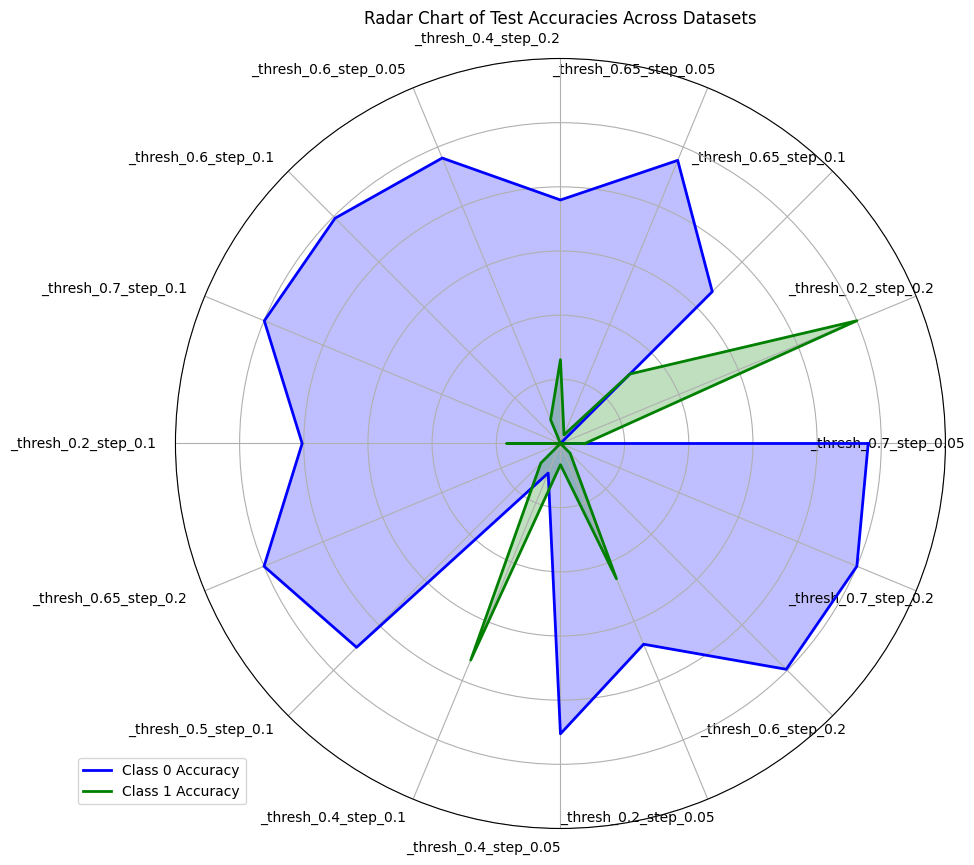

In [42]:
from math import pi

def visualize_test_accuracies_radar(results):
    # Extract the substring after "FINISHED_PRODUCT" for each label
    labels = [label.split('FINISHED_PRODUCT')[-1] for label in results.keys()]
    num_vars = len(labels)

    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    # Class 0
    values_0 = [res[5] for res in results.values()]
    values_0 += values_0[:1]
    ax.plot(angles, values_0, color='blue', linewidth=2, linestyle='solid', label='Class 0 Accuracy')
    ax.fill(angles, values_0, color='blue', alpha=0.25)

    # Class 1
    values_1 = [res[6] for res in results.values()]
    values_1 += values_1[:1]
    ax.plot(angles, values_1, color='green', linewidth=2, linestyle='solid', label='Class 1 Accuracy')
    ax.fill(angles, values_1, color='green', alpha=0.25)

    # Increase the radial limit (circle size)
    ax.set_ylim(0, 1)
    ax.set_rmax(1.2)  # Increase this value to make the circle larger

    ax.set_yticklabels([])

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.title("Radar Chart of Test Accuracies Across Datasets")
    plt.show()

visualize_test_accuracies_radar(results)


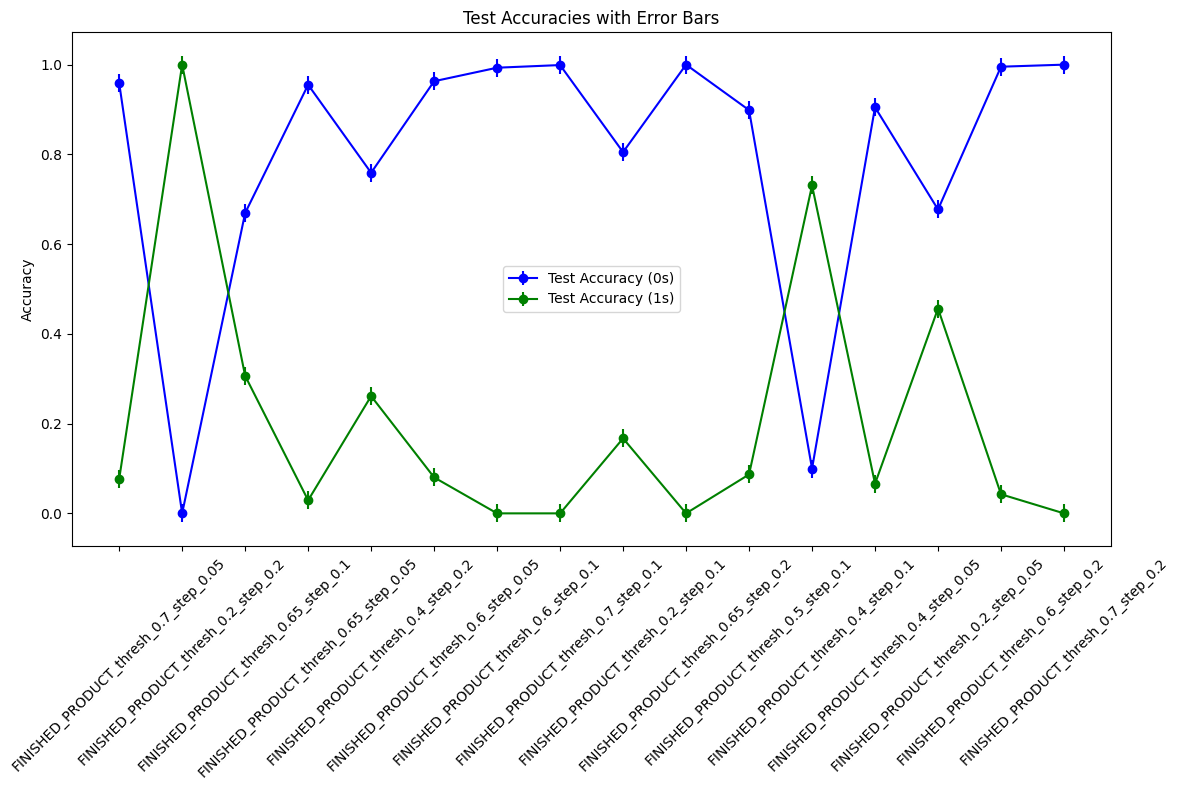

In [36]:
def visualize_test_accuracies_line(results):
    labels = list(results.keys())
    test_accuracies_0 = [res[5] for res in results.values()]
    test_accuracies_1 = [res[6] for res in results.values()]

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.errorbar(labels, test_accuracies_0, yerr=[0.02] * len(labels), label="Test Accuracy (0s)", fmt='-o', color='blue')
    ax.errorbar(labels, test_accuracies_1, yerr=[0.02] * len(labels), label="Test Accuracy (1s)", fmt='-o', color='green')

    ax.set_ylabel("Accuracy")
    ax.set_title("Test Accuracies with Error Bars")
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

visualize_test_accuracies_line(results)


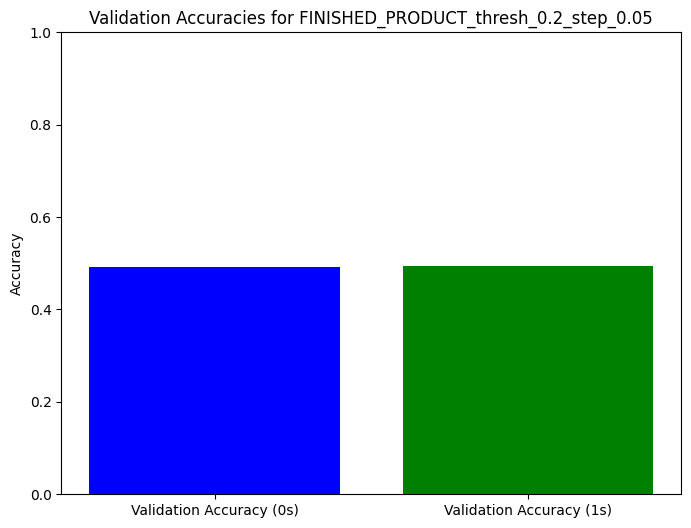

In [51]:
import matplotlib.pyplot as plt

# Choose one directory from the results dictionary
directory_name = list(results.keys())[-3]  # This will pick the first directory in the results dictionary

# Extract the validation accuracies for this directory
_, _, _, val_accuracy_0, val_accuracy_1, _, _ = results[directory_name]

# Plot the validation accuracies
plt.figure(figsize=(8, 6))
plt.bar(['Validation Accuracy (0s)', 'Validation Accuracy (1s)'], [val_accuracy_0, val_accuracy_1], color=['blue', 'green'])
plt.ylabel("Accuracy")
plt.title(f"Validation Accuracies for {directory_name}")
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.show()
